<center><b><font size=6>Supervised learning – classification<b><center>

This notebook implements the supervised learning component of the SSH Shell Attack session project. The goal is to classify attack session tactics based on the provided dataset.

0. **Install Dependencies**
1. **Data Splitting**
2. **Baseline Model Implementation**
3. **Hyperparameter Tuning**
4. **Result Analysis**  
5. **Feature Experimentation**

<center><b><font size=5>Install Dependencies<b><center>

In [2]:
!python ../scripts/install_dependencies.py section2

Installing common packages: pandas, pyarrow
Installing Section 2 packages: matplotlib, seaborn, scikit-learn


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

<center><b><font size=5>Data Splitting<b><center>

Split the dataset into training and testing sets.

"Perform a split to segment the dataset into training and test dataset.
If you want to standardize your dataset, fit the scaler on training set and transforming both training
and test. Notice that the sklearn implementation of tf-idf already performs the standardization."

**Steps:**

- Data Loading
- Inspect the Dataset
- Dataset Profiling (Optional)
- Data Splitting
- Multi-Label Transformation
- Summary

### Load the dataset

- Loads the dataset from a Parquet file into a Pandas DataFrame.

In [8]:
# Dataset intero
SSH_Attacks = pd.read_parquet("../data/processed/ssh_attacks_decoded.parquet")
#SSH_Attacks

In [9]:
SSH_Attacks_bow_sampled = pd.read_parquet("../data/processed/BOW_DATASETS/ssh_attacks_bow_sampled.parquet")
#SSH_Attacks_bow_sampled

In [10]:
SSH_Attacks_tfidf_sampled = pd.read_parquet("../data/processed/TFIDF_DATASETS/ssh_attacks_tfidf_sampled.parquet")
#SSH_Attacks_tfidf_sampled

### Inspect the Dataset

- Validate the structure, variability, and characteristics of the dataset.


_Suggestions:_
  - _Add checks for missing or null values using `SSH_Attacks.isnull().sum(`._
  - _Verify that the `Set_Fingerprin` column contains valid labels._

In [11]:
# Display the first few rows of the dataset
print("\nDataset Head:\n")
print(SSH_Attacks_tfidf_sampled.head())  # Useful to quickly verify the structure of the dataset

# Display a random sample of 5 rows to get an idea of the dataset's variability
print("\nRandom Sample:\n")
print(SSH_Attacks_tfidf_sampled.sample(5))

# Provide an overview of the dataset, including column data types and memory usage
print("\nDataset Overview:\n")
print(SSH_Attacks_tfidf_sampled.info(memory_usage='deep'))  # Using 'deep' to handle potential memory usage issues

# Display summary statistics for selected columns
print("\nSummary Statistics (Selected Columns):\n")
print(SSH_Attacks_tfidf_sampled[['Set_Fingerprint']].describe(include='all'))  # Focus on simpler columns


Dataset Head:

                 Set_Fingerprint    enable    system   sh  cat  proc  \
45459   [Discovery, Persistence]  0.136394  0.068782  0.0  0.0   0.0   
73366   [Discovery, Persistence]  0.136394  0.068782  0.0  0.0   0.0   
142247  [Discovery, Persistence]  0.136394  0.068782  0.0  0.0   0.0   
207369  [Discovery, Persistence]  0.136394  0.068782  0.0  0.0   0.0   
187475  [Discovery, Persistence]  0.136394  0.068782  0.0  0.0   0.0   

          mounts  bin  busybox   cd  ...  top  sleep       tar    passwd   nc  \
45459   0.252226  0.0      0.0  0.0  ...  0.0    0.0  0.340026  0.068061  0.0   
73366   0.252226  0.0      0.0  0.0  ...  0.0    0.0  0.340026  0.068061  0.0   
142247  0.252226  0.0      0.0  0.0  ...  0.0    0.0  0.340026  0.068061  0.0   
207369  0.252226  0.0      0.0  0.0  ...  0.0    0.0  0.340026  0.068061  0.0   
187475  0.252226  0.0      0.0  0.0  ...  0.0    0.0  0.340026  0.068061  0.0   

           mkdir  unix        mv  nohup      tsm  
45459   0.204

### Dataset Profiling

- Measure execution time for the dataset overview


_Suggestions:_

- _This is unnecessary unless profiling the dataset inspection step is critical._
- _Consider removing this for simplicity._

In [13]:
print("\nExecution time for the dataset overview:\n")
start_time = time.time()
print(SSH_Attacks_tfidf_sampled.info(memory_usage='deep'))  # Repeat to observe any differences or delays
print("\nExecution Time: {:.2f} seconds".format(time.time() - start_time))  # Outputs time taken for the operation


Execution time for the dataset overview:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23325 entries, 45459 to 232782
Data columns (total 46 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Set_Fingerprint  23325 non-null  object 
 1   enable           23325 non-null  float64
 2   system           23325 non-null  float64
 3   sh               23325 non-null  float64
 4   cat              23325 non-null  float64
 5   proc             23325 non-null  float64
 6   mounts           23325 non-null  float64
 7   bin              23325 non-null  float64
 8   busybox          23325 non-null  float64
 9   cd               23325 non-null  float64
 10  dev              23325 non-null  float64
 11  cp               23325 non-null  float64
 12  echo             23325 non-null  float64
 13  tftp             23325 non-null  float64
 14  wget             23325 non-null  float64
 15  dd               23325 non-null  float64
 16  bs        

### Data Splitting

- Define Features (X) and Labels (y)
- Split Data into Training and Testing Sets
- Preprocess Text Data
- Vectorize Text with TF-IDF


_Suggestions:_

- _point 1. Validate that full_session and Set_Fingerprint do not have null values using: print(X.isnull().sum(), y.isnull().sum())_
- _point 2. Stratify the split if the label distribution is imbalanced using: train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)_
- _point 2. Check the distribution of labels in training and test sets._
- _point 3. Add a basic cleaning step if the text contains unwanted characters or casing._
- _point 4. Explore hyperparameters like ngram_range, min_df, and max_df to see their effect on performance._
- _point 4. Use stop_words='english' to remove common but non-informative words._

In [5]:
# Isolate the text data (X) and labels (y).
X = SSH_Attacks['full_session']     # Text data
y = SSH_Attacks['Set_Fingerprint']  # Multi-label target

# Ensure a 70/30 split while maintaining reproducibility (random_state=42).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Convert to strings to ensure compatibility with TfidfVectorizer
X_train = X_train.astype(str)
X_test = X_test.astype(str)

# Vectorize the text data using TF-IDF (standardization is included in TF-IDF by default)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Multi-Label Transformation

- Transform Labels to Binary Format


_Suggestions:_

- _Check for any inconsistencies in label transformation: print(y_train_binary.head(), y_test_binary.head())_
- _Verify that `mlb.classes` matches the expected categories._

In [6]:
# Converts multi-label data into a binary matrix suitable for classification.
y_train_list = y_train.apply(lambda x: set(x))
y_test_list = y_test.apply(lambda x: set(x))

mlb = MultiLabelBinarizer()
y_train_binary = pd.DataFrame(mlb.fit_transform(y_train_list), columns=mlb.classes_, index=y_train.index)
y_test_binary = pd.DataFrame(mlb.transform(y_test_list), columns=mlb.classes_, index=y_test.index)

### Summary

- Ensures the processed data is correctly prepared for modeling.


_Suggestions:_

- _Check the sparsity of X_train_tfidf and X_test_tfidf: print("Train Sparsity:", (X_train_tfidf.nnz / np.prod(X_train_tfidf.shape)) * 100) print("Test Sparsity:", (X_test_tfidf.nnz / np.prod(X_test_tfidf.shape)) * 100)_

In [7]:
# Print basic info about the processed data
print("\nProcessed Training set size:", len(X_train))
print("\nProcessed Testing set size:", len(X_test))
print("\nClasses:", mlb.classes_)


Processed Training set size: 163124

Processed Testing set size: 69911

Classes: ['Defense Evasion' 'Discovery' 'Execution' 'Harmless' 'Impact' 'Other'
 'Persistence']


<center><b><font size=5>Baseline Model Implementation<b><center>

Train at least two ML models and evaluate their performance.

"Choose at least 2 ML methods, and perform the model training, with default parameter
configuration, evaluating the performance on both training and test set. Output the confusion
matrix and classification report. Do you observe overfitting or under-fitting? Which model
generates the best performance?"

**Steps:**

- Choose different ML models (e.g., Logistic Regression and Random Forest).
- Logistic Regression - Training and Evaluation.
- Random Forest - Training and Evaluation.
- Support Vector Machine (SVM) - Training and Evaluation.
- Compare performance and check for overfitting/underfitting.

### Choose and initialize models

- text

In [8]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear', random_state=42)
}

# Store results for comparison
model_results = {}



In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def train_and_evaluate(model, model_name, X_train, X_test, y_train_binary, y_test_binary):
    """
    Train a given model for each label and evaluate its performance.
    
    Args:
        model: An initialized ML model.
        model_name: Name of the model (string).
        X_train, X_test: TF-IDF-transformed training and test data.
        y_train_binary, y_test_binary: Binary label data for training and testing.
    
    Returns:
        results: A dictionary containing classification reports and confusion matrices for all labels.
    """
    results = {}
    
    # Create an empty DataFrame to store predictions for multilabel compatibility
    y_pred = pd.DataFrame(index=y_test_binary.index, columns=y_test_binary.columns)
    
    # Initialize the plot with a grid of subplots (3 rows, 3 columns)
    fig, axes = plt.subplots(3, 3, figsize=(18, 14))  # Adjusted figsize for better spacing
    axes = axes.flatten()  # Flatten to make it easier to access individual axes
    
    # Train and evaluate for each label
    for i, label in enumerate(y_train_binary.columns):
        
        print(f"\n{'='*69}\n  TRAINING FOR LABEL: {label} ({model_name})\n{'='*69}\n")
        
        # Train the model
        model.fit(X_train, y_train_binary[label])
        
        # Predict and store the results in the corresponding column
        y_pred[label] = model.predict(X_test)
        
        # Generate and store classification report
        report = classification_report(
            y_test_binary[label], 
            y_pred[label], 
            zero_division=0, # To avoid the warning for precision and F-score.
        )
        results[label] = {"classification_report": report}
        
        # Display classification report
        print(f"\nClassification Report for {label}:\n")
        print(report)
        
        # Generate and display confusion matrix
        print(f"Confusion Matrix for {label}:\n")
        cm = confusion_matrix(y_test_binary[label], y_pred[label])
        results[label]["confusion_matrix"] = cm
        
        # Plot the confusion matrix with improved aesthetics
        ax = axes[i]  # Access the i-th subplot
        
        sns.set(font_scale=1.3)  # Adjust font size for better readability
        sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=True, 
                    xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"],
                    annot_kws={"size": 14, "weight": 'bold'}, linewidths=1.2, linecolor='gray', ax=ax)
        
        ax.set_title(f"Confusion Matrix for {label} - {model_name}", fontsize=10, weight='bold')
        ax.set_ylabel('True Label', fontsize=12)
        ax.set_xlabel('Predicted Label', fontsize=12)
        
        # Customize tick params for readability
        ax.tick_params(axis='both', labelsize=12)
        
        # Set axis labels in a larger font and remove unnecessary gridlines
        ax.yaxis.set_tick_params(width=1.2)
        ax.xaxis.set_tick_params(width=1.2)
    
    # Remove the extra empty subplot (if any)
    if len(y_train_binary.columns) < 9:
        fig.delaxes(axes[-1])  # Delete the last empty axis if there are fewer than 9 labels

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    
    return results


### Logistic Regression

- Training
- Evaluation (confusion matrix and classification report)


Training and Evaluating: Logistic Regression

  TRAINING FOR LABEL: Defense Evasion (Logistic Regression)


Classification Report for Defense Evasion:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64277
           1       0.98      0.96      0.97      5634

    accuracy                           1.00     69911
   macro avg       0.99      0.98      0.99     69911
weighted avg       1.00      1.00      1.00     69911

Confusion Matrix for Defense Evasion:


  TRAINING FOR LABEL: Discovery (Logistic Regression)


Classification Report for Discovery:

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       252
           1       1.00      1.00      1.00     69659

    accuracy                           1.00     69911
   macro avg       0.96      0.94      0.95     69911
weighted avg       1.00      1.00      1.00     69911

Confusion Matrix for Discovery:


  TRAINING FOR LABEL: Exe

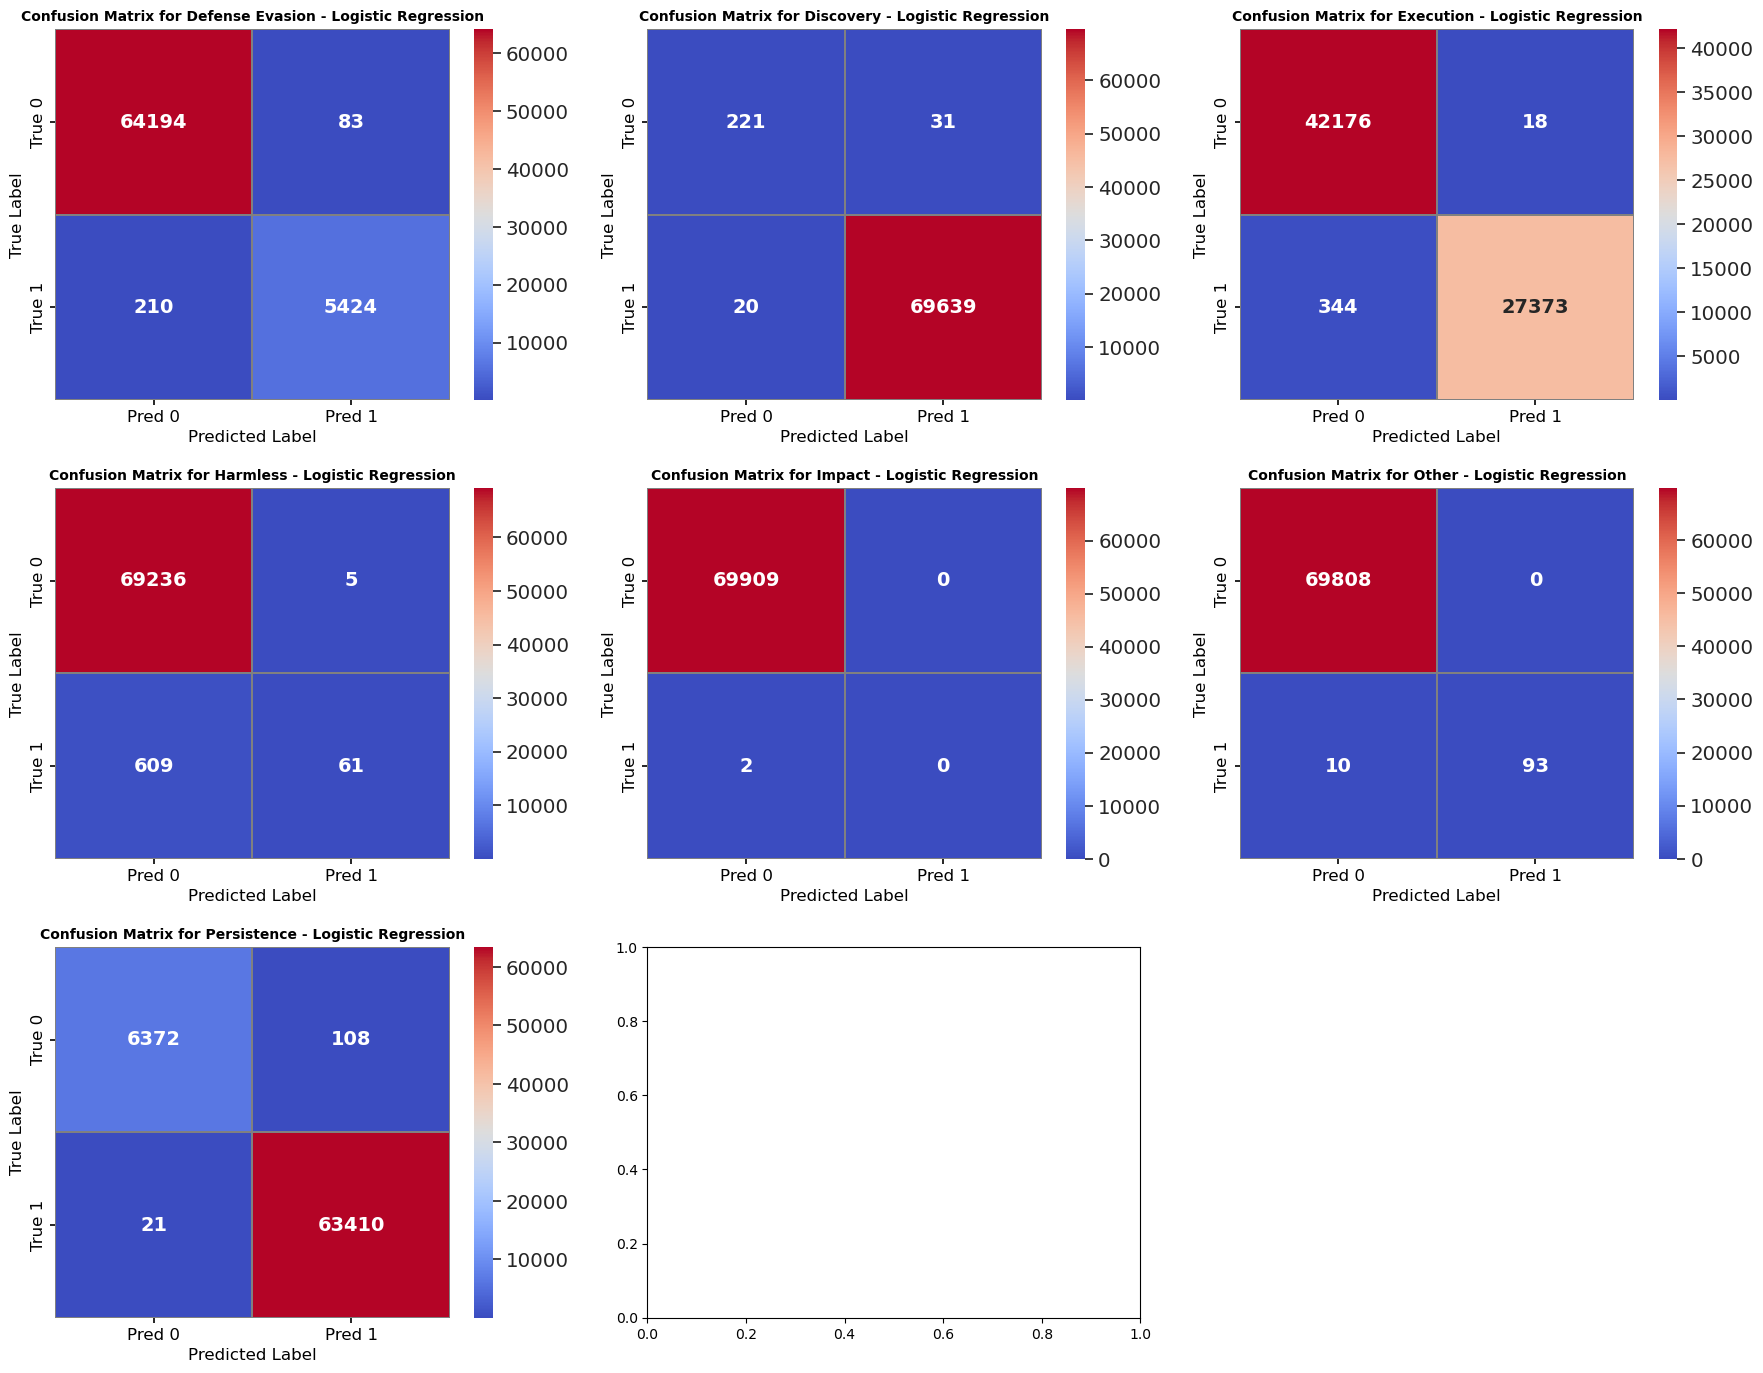

In [10]:
# Train and evaluate Logistic Regression
model_name = "Logistic Regression"
model = models[model_name]

print(f"\nTraining and Evaluating: {model_name}")

model_results[model_name] = train_and_evaluate(
    model, model_name, X_train_tfidf, X_test_tfidf, y_train_binary, y_test_binary
)

### Random Forest

- Training
- Evaluation (confusion matrix and classification report)


Training and Evaluating: Random Forest

  TRAINING FOR LABEL: Defense Evasion (Random Forest)


Classification Report for Defense Evasion:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64277
           1       0.99      0.97      0.98      5634

    accuracy                           1.00     69911
   macro avg       1.00      0.98      0.99     69911
weighted avg       1.00      1.00      1.00     69911

Confusion Matrix for Defense Evasion:


  TRAINING FOR LABEL: Discovery (Random Forest)


Classification Report for Discovery:

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       252
           1       1.00      1.00      1.00     69659

    accuracy                           1.00     69911
   macro avg       0.97      0.97      0.97     69911
weighted avg       1.00      1.00      1.00     69911

Confusion Matrix for Discovery:


  TRAINING FOR LABEL: Execution (Random For

KeyboardInterrupt: 

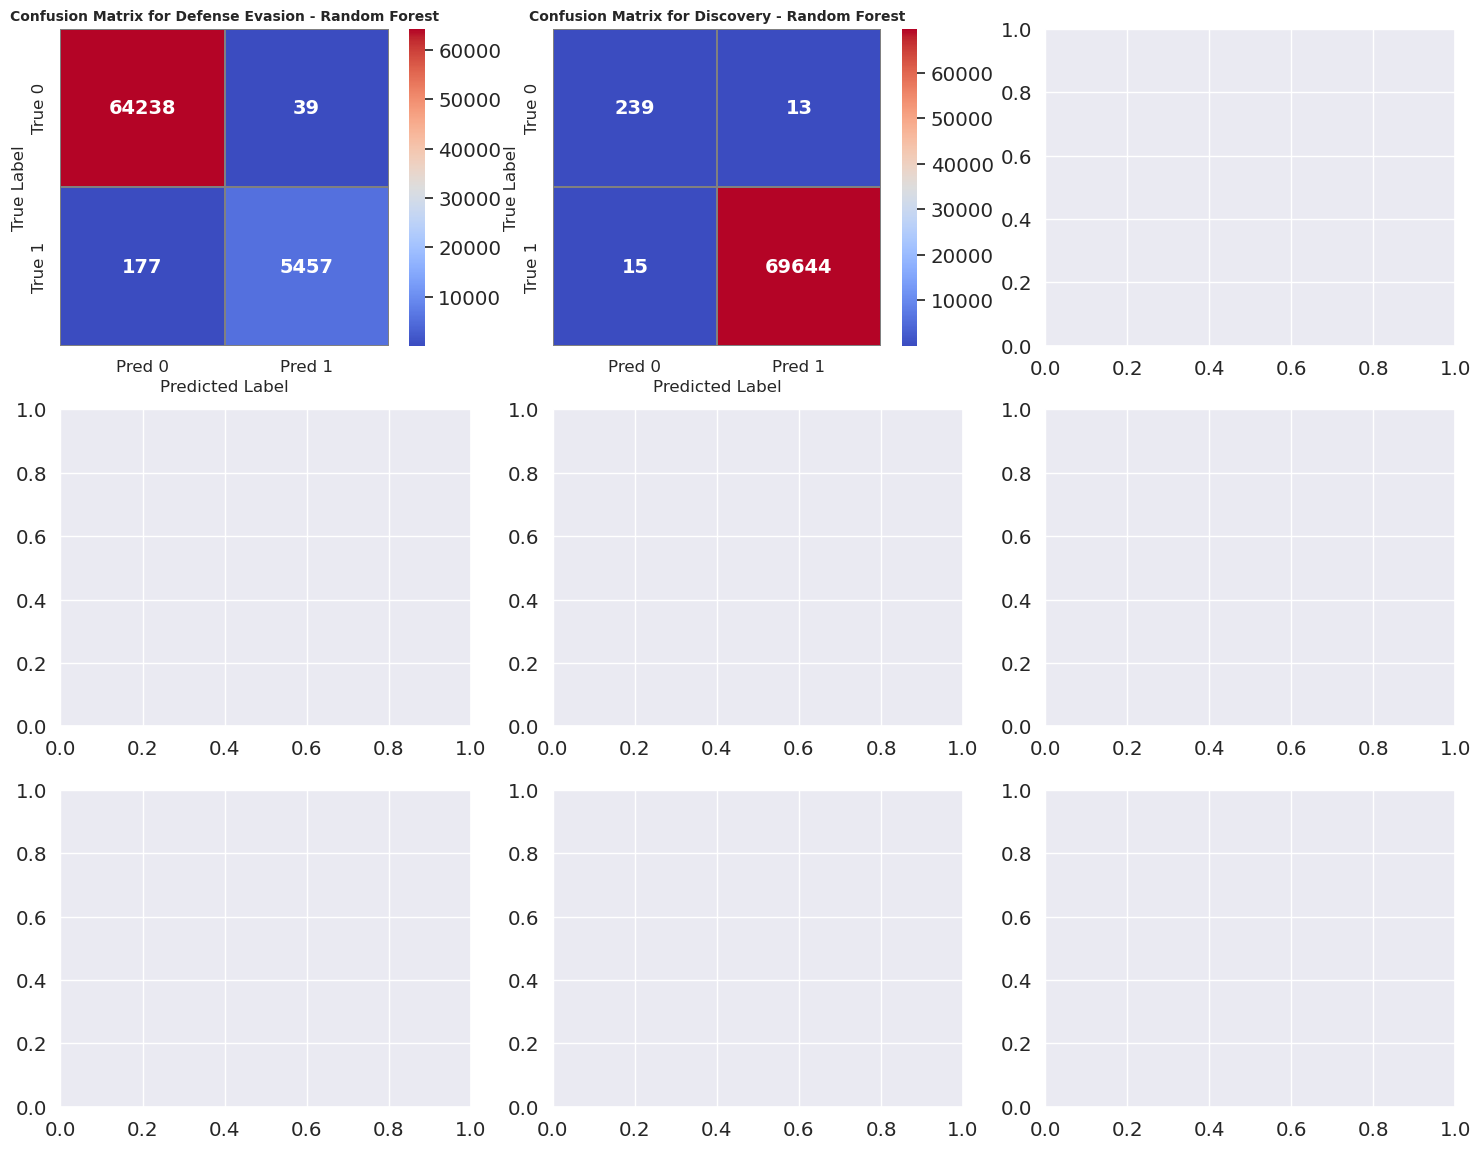

In [11]:
# Train and evaluate Random Forest
model_name = "Random Forest"
model = models[model_name]

print(f"\nTraining and Evaluating: {model_name}")

model_results[model_name] = train_and_evaluate(
    model, model_name, X_train_tfidf, X_test_tfidf, y_train_binary, y_test_binary
)

### Support Vector Machine (SVM)

- Training
- Evaluation (confusion matrix and classification report)

In [ ]:
# Train and evaluate SVM
model_name = "SVM"
model = models[model_name]

print(f"\nTraining and Evaluating: {model_name}")

model_results[model_name] = train_and_evaluate(
    model, model_name, X_train_tfidf, X_test_tfidf, y_train_binary, y_test_binary
)

### Compare performances

"Do you observe overfitting or under-fitting? Which model generates the best performance?"

- text
- text

In [ ]:
# Function to calculate and display performance metrics
def compare_performances(model_results, y_train_binary, y_test_binary):
    comparison = []
    
    # Iterate through the results of each model
    for model_name, results in model_results.items():
        print(f"\n{'#'*40}\nPerformance Summary for {model_name}\n{'#'*40}")
        
        # Extract predictions and evaluate on training set
        y_train_pred = results['train_predictions']
        y_test_pred = results['test_predictions']
        
        # Compute metrics for training set
        train_report = classification_report(
            y_train_binary, y_train_pred, zero_division=0, output_dict=True
        )
        train_f1 = train_report['weighted avg']['f1-score']
        train_accuracy = train_report['accuracy']
        
        # Compute metrics for test set
        test_report = classification_report(
            y_test_binary, y_test_pred, zero_division=0, output_dict=True
        )
        test_f1 = test_report['weighted avg']['f1-score']
        test_accuracy = test_report['accuracy']
        
        # Store comparison metrics
        comparison.append({
            "Model": model_name,
            "Train Accuracy": train_accuracy,
            "Test Accuracy": test_accuracy,
            "Train F1-Score": train_f1,
            "Test F1-Score": test_f1,
            "Overfitting": train_accuracy - test_accuracy
        })
        
        # Print confusion matrix and classification report for the test set
        print("\nTest Set Confusion Matrix:")
        cm = confusion_matrix(y_test_binary.values.argmax(axis=1), y_test_pred.argmax(axis=1))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"Confusion Matrix - {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()
        
        print("Classification Report (Test Set):\n")
        print(classification_report(y_test_binary, y_test_pred, zero_division=0))
    
    # Convert comparison to DataFrame for easy visualization
    comparison_df = pd.DataFrame(comparison)
    
    # Highlight the best-performing model
    best_model = comparison_df.sort_values(by="Test Accuracy", ascending=False).iloc[0]
    print(f"\n{'#'*40}\nBest Model: {best_model['Model']}\n{'#'*40}")
    print(f"Test Accuracy: {best_model['Test Accuracy']:.2f}")
    print(f"Test F1-Score: {best_model['Test F1-Score']:.2f}")
    
    return comparison_df

In [13]:
# Compare performances of all models
performance_comparison = compare_performances(model_results, y_train_binary, y_test_binary)

# Display comparison table
performance_comparison.sort_values(by="Test Accuracy", ascending=False)


########################################
Performance Summary for Logistic Regression
########################################


KeyError: 'train_predictions'

<center><b><font size=5>Hyperparameter Tuning<b><center>

Fine-tune the hyperparameters of the ML models using cross-validation.

"Tune the hyper-parameters of the models through cross-validation. How do performance vary?"

**Steps:**

TO BE CHECKED

- Use GridSearchCV or RandomizedSearchCV to tune hyperparameters.
- Evaluate the performance of the tuned models.
- Compare the results with baseline performance.

### text

- text
- text

### text

- text
- text

### text

- text
- text

<center><b><font size=5>Result Analysis<b><center>

Analyze and summarize the results for each intent.

"Comments on the results for each on the intents."

**Steps:**

- Compare confusion matrices and classification reports.
- Highlight trends and insights for each intent.
- Summarize findings and discuss implications.

### text

- text
- text

### text

- text
- text

### text

- text
- text

<center><b><font size=5>Feature Experimentation<b><center>

Explore the impact of different features on model performance.

"Explore the possible features: try combining features differently, e.g., does tf-idf improve or worsen
performance? Think about the problem and summarize the ways you have tried (even those that
did not work)."

**Steps:**

- Experiment with feature combinations (e.g., adding temporal features).
- Observe performance changes with each combination.
- Document successful and unsuccessful experiments.

### text

- text
- text

### text

- text
- text

### text

- text
- text